### I. Libary import

In [3]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
# from xgboost import XGBRegressor

from src import data_preprocessing as dp
from src import pipeline as pl
from src import new_feature_engineering_daily as fe
from src import feature_selection as fs
from src.model_evaluation import evaluate, evaluate_multi_output
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED)

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### I. Data prepare

https://www.canva.com/design/DAG4R7QKlV8/RDuGQEKDWbv8IO4TBiZfWg/edit?utm_content=DAG4R7QKlV8&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton

In [5]:
# 1. Load raw Data
df = dp.load_data(r'data/raw data/Hanoi Daily 10 years.csv')

# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

# 4. Fit preprocessing pipeline trên train
pipeline1 = pl.build_preprocessing_pipeline()
pipeline1.fit(train_df)

# 5. Transform cả train và test
train_processed = pipeline1.transform(train_df)
test_processed = pipeline1.transform(test_df)

# 6. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

# 7. Fit preprocessing pipeline trên train
pipeline1 = pl.build_preprocessing_pipeline()
pipeline1.fit(train_df)

# 8. Transform cả train và test
train_processed = pipeline1.transform(train_df)
test_processed = pipeline1.transform(test_df)

# 9. Lưu lại pipeline 1
# joblib.dump(pipeline1, r"pipelines\preprocessing_pipeline.pkl")

 Loaded data with shape: (3660, 33)
Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'


### II. Feature Engineering and Training Model

## 2.1 OVERVIEW

### **2.1.1. Forecasting Architectures**

#### **1. Recursive Strategy**
**Method:**  
A single model is trained to predict only one step ahead (t + 1).  
To forecast t + 2, the model’s own prediction for t + 1 is fed back into its input features.  
This process is repeated for each subsequent step.

**Drawback:**  
This approach is highly susceptible to **error accumulation** — any small error in the t + 1 forecast becomes part of the input for t + 2, and the errors compound over time.  
Performance therefore degrades quickly for longer horizons.

**When to use:**  
Useful for short-term forecasts where the system dynamics are stable and small accumulated errors have minimal effect.

#### **2. Multi-Output Strategy**
**Method:**  
A single, more complex model is trained to predict multiple future time steps (t + 1 → t + 5) simultaneously in one forward pass.

**Drawback:**  
This model acts as a **generalist** — while computationally efficient, it often struggles to optimize each specific horizon, producing good but not optimal results for any particular forecast step.

**When to use:**  
When efficiency and simultaneous multi-step outputs are more important than maximizing accuracy at a specific horizon.

#### **3. Direct Strategy *(Chosen Approach)***
**Method:**  
Train a **separate, independent model** for each forecast horizon.  
For example, the model for t + 3 is trained exclusively on data pairs of *(Features at time t, Target at time t + 3)*.  
In our case, we train **five separate models**, one for each horizon (t + 1 → t + 5).

**Justification:**  
This strategy is the **most robust and accurate** for our problem.  
It avoids recursive error propagation and allows each model to specialize in the unique temporal relationships relevant to its forecast distance.  
Although it requires training multiple models, the gain in accuracy and reliability justifies the extra computational cost, especially since our dataset per day is relatively small.

---

### **2.1.2. Metrics Explanation (MAE, RMSE, R²)**

In this project, we evaluate our weather forecasting models using three main regression metrics: **Mean Absolute Error (MAE)**, **Root Mean Squared Error (RMSE)**, and the **Coefficient of Determination (R²)**.  
Each metric provides a different perspective on model performance and together they give a more complete evaluation.

#### **1. Mean Absolute Error (MAE)**

**Formula:**

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

**Meaning:**  
MAE measures the **average absolute difference** between predicted and actual values.  
It tells us, on average, how much the predictions deviate from the true observations — regardless of direction (positive or negative).

**Characteristics:**
- Interpretable in the same unit as the target variable (e.g., °C for temperature).
- Less sensitive to large outliers.
- Easier to interpret and explain to non-technical audiences.

#### **2. Root Mean Squared Error (RMSE)**

**Formula:**

$$
RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

**Meaning:**  
RMSE measures the **square root of the average squared error**.  
It penalizes larger errors more heavily than MAE, which makes it useful for emphasizing cases where the model performs particularly poorly.

**Characteristics:**
- Sensitive to outliers and large deviations.  
- Provides stronger penalty for big mistakes → better for highlighting unstable models.
- Has the same unit as the target variable (°C).


#### **3. Coefficient of Determination (R² Score)**

**Formula:**

$$
R^2 = 1 - \frac{ \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 }{ \sum_{i=1}^{n}(y_i - \bar{y})^2 }
$$

**Meaning:**  
R² represents the **proportion of variance** in the target variable that can be explained by the model.  
The closer R² is to 1, the better the model explains the data variability.

**Interpretation:**
- \( R^2 = 1 \): Perfect prediction.  
- \( R^2 = 0 \): Model performs no better than simply predicting the mean.  
- \( R^2 < 0 \): Model performs worse than predicting the mean.


#### **4. Implementation in Our Project**

We use the function `evaluate_multi_output()` defined in the `model_evaluation.py` file to compute these metrics.  
**Inputs:**  
- `y_true`: True target values (actual weather data).  
- `y_pred`: Predicted values from our trained models.  

**Outputs:**  
- Dictionary containing `MAE`, `RMSE`, and `R²` scores for each forecast horizon.

This allows us to evaluate each of our five direct models (t+1 → t+5) consistently and compare their performance.


#### **5. Metric Prioritization**

Although all metrics are reported for completeness, our group **prioritizes RMSE** for model optimization.

**Reasoning:**
- RMSE strongly penalizes large prediction errors, which is important for weather forecasting where a few extreme wrong predictions (e.g., 5–6°C off) can be more harmful than small consistent ones.
- RMSE thus encourages the model to perform more consistently and handle variability better.

During evaluation, we still analyze **MAE** and **R²** alongside RMSE to ensure a balanced understanding of model accuracy and reliability.


**➡️ In short:**  
We evaluate with all three metrics but **optimize for RMSE** to achieve a more stable and accurate forecasting performance.


### **2.1.3. Cách đánh giá**
Ngoài việc chia train, test thì trong quá trình tuning và so sánh giữa các phương pháp mình sẽ sử dụng Cross-Val trên train. Vẽ cho t cái biểu đồ tiếp (nếu biểu đồ tổng quát có cụ thể rồi thì thôi)


Đây là đoạn t viết để giải thích chung chung, (ai đọc thì check xem t vt đúng luôn không) cho mọi người. Người viết tóm tắt ngắn gọn lại quy trình thôi

- Workflow: Trong quá trình so sánh các phương án, tuning chỉ dùng dữ liệu trên tập train (tập này sẽ được chia thành 5 cross-validation - tức 5 cặp train/ test nhỏ - và mình sẽ đánh giá mức độ dự đoán và ổn định của model trên các cặp train/ test này)

=> Tìm được phương án tốt nhất rồi thì mới training lại và đánh giá lần cuối trên toàn bộ train và test set.

- Phần so sánh việc drop base, hay xử lí cate: Mấy bạn viết report kết quả, Ngoài việc sử dụng (Metrics trung bình của 5 tập hay Std của 5 tập - thể hiện mức độ biến động/ ổn định giữa các fold) tìm thêm biểu đồ biểu như kiểu box plot (thầy Long) để trực quan hoá, nhớ là kèm giải thích ngắn gọn

### **2.1.4. Nói qua Công cụ Tuning mình dùng - Nhàn**
- Optuna để tuning
- ClearML để lưu kết quả: Chụp ảnh màn hình, xong về mục artifact mình sẽ log những gì, scalar log những gì, ... Thêm link CLearML vào đây

Nhàn lên được ClearML nên viết phần này

## **2.2 Feature engineering and Training**

### **2.2.1. Linear Model**
### MNG ĐỌC
- Đang để tune riêng 5 model, Mà kết quả tune nó hơi lạ, Nhàn tune Linear (Ridge) tiếp cho t, kết quả bất lực quá thì thôi tune để lấy số liệu, với biểu đồ so sánh giúp mình đưa ra kết luận là chọn Tree(lgb) thôi

- Hoàng chịu khó cop lại rồi thay lgb vào hoặc viết mới, sửa lại các kiểu tuỳ

- Ai tune thì chú ý cũng chưa có mấy cái biểu đồ hình vẽ  như vis.plot_parallel_coordinate(study_grad), vis.plot_param_importances(study=study_grad), vis.plot_slice(study=study_grad). Mng cho thêm vào, tại mk cũng sẽ cần cho 1-2 cái vào report để nói về quá trình tune + kèm giải thích ngắn

In [ ]:
# Đây là mấy cái biểu đồ cũ lúc tuning mình dùng, mọi người tự ghép vào

# === Vẽ biểu đồ RMSE theo trial  ===
# fig3 = plt.figure(figsize=(7, 4))
# plt.plot([t.value for t in study_grad.trials])
# plt.xlabel("Trial")
# plt.ylabel("RMSE")
# plt.title("Optuna RMSE per Trial")

# logger_grad.report_matplotlib_figure(
#     title="Optuna Performance",
#     series="RMSE Curve",
#     figure=fig3,
#     iteration=len(study_grad.trials)
# )
# plt.close(fig3)

# vis.plot_parallel_coordinate(study_grad)
# vis.plot_slice(study=study_grad)
# vis.plot_param_importances(study=study_grad)

### **2.2.2. Giới thiệu Ridge**

Ridge Regression is a type of **linear regression** that includes **L2 regularization**, which helps prevent overfitting by penalizing large model coefficients.  
In the context of weather prediction, Ridge is an appropriate baseline model because it can capture the **linear relationships** between meteorological factors (such as temperature, humidity, and pressure) while remaining stable even when features are correlated.


#### Key Characteristics
- **Simple and interpretable:** Ridge provides direct insight into how each feature affects the prediction.  
- **Regularization (L2 penalty):** Prevents the model from assigning excessively high weights to correlated or noisy features.  
- **Good with multicollinearity:** Works well when predictors (like temperature, humidity, and radiation) are correlated — a common situation in weather data.  
- **Fast training:** Computationally efficient, making it suitable for initial modeling or feature selection stages.

#### Why Ridge Fits Our Forecasting Goal
For our dataset on Hanoi weather, Ridge serves as a **strong linear baseline**:
- It captures direct linear dependencies among weather indicators.  
- It benefits from the engineered interaction features and scaling pipeline built earlier.  
- It helps identify which features have the most consistent influence on temperature or weather conditions.

Although more advanced models (like LightGBM) may later achieve better accuracy, Ridge Regression provides a **robust, explainable, and well-regularized foundation** for understanding the structure of our data.

- Đoạn linear này nói chung là Sương mai làm cho t bản tóm tắt kết quả lại, xong kết luận luôn là mình sẽ chọn tree base (LGB), còn bên dưới là quá trình chạy thử, tuning các thứ nếu thầy muốn xem

### 1.2. Input preparation (Feature Engineering and Selection) for linear model (Ridge)  - Sương Mai, Nhàn

In [6]:
## lưu ý khi tune linear này sẽ khác so với LGB

# 1. có sử dụng các biến interaction: is_linear = True

# Tạo feature engineering (drop NaN sau khi rolling/lag)
train_feat, target_col = fe.feature_engineering(train_processed, is_drop_nan= True, is_linear= True)
test_feat, _ = fe.feature_engineering(test_processed, is_drop_nan= True, is_linear= True)

# Chia X, y riêng biệt
X_train = train_feat.drop(columns= target_col)
y_train = train_feat[target_col]

X_test = test_feat.drop(columns= target_col)
y_test = test_feat[target_col]


# 2. Encoding sang numeric
encoder = pl.build_encoding_pipeline(is_category= False)
encoder.fit(X_train, X_train['temp'])

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)


print(f"Train: {X_train.shape, y_train.shape}, Test: {X_test.shape, y_test.shape}")

cat_features = X_train.select_dtypes(include=['category','object']).columns
print('\nKiểm tra còn biến object hay category', len(cat_features))


# 3. Drop base
print('\nDrop Base')
print('số lượng Trước Khi drop base', X_train.shape, X_test.shape)
X_train = fe.drop_base_features(X_train)
X_test = fe.drop_base_features(X_test)
print('số lượng sau drop base', X_train.shape, X_test.shape)



Đã tạo 7 biến interaction
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Đã tạo 7 biến interaction
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Train: ((2893, 264), (2893, 5)), Test: ((697, 264), (697, 5))

Kiểm tra còn biến object hay category 0

Drop Base
số lượng Trước Khi drop base (2893, 264) (697, 264)
số lượng sau drop base (2893, 243) (697, 243)


#### 1.3. Tuning trên cross-validation

In [7]:
# Nhớ đổi tên task trong task_name

if Task.current_task():
    Task.current_task().close()

task_lgbm = Task.init(
    project_name="Temperature Forecasting",         # tên project trên ClearML (nếu chưa có sẽ tự tạo)
    task_name="Ridge Optuna Tuning 1",            # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print(" Task created successfully!")
print("Task ID:", task_lgbm.id)

MissingConfigError: It seems ClearML is not configured on this machine!
To get started with ClearML, setup your own 'clearml-server' or create a free account at https://app.clear.ml
Setup instructions can be found here: https://clear.ml/docs

In [ ]:
task_lgbm = Task.get_task(task_id="59847c902e2d4035b6d4bb584e1b3a78")
logger_lgbm = task_lgbm.get_logger()

### A. Chạy thử với các hyper parameter mặc định

Before training the **Ridge Regression model**, several preprocessing classes were implemented to clean, encode, and transform the dataset.  
These custom classes prepare the input data so that the pipeline can work efficiently and produce stable predictions.

#### **1. `HandleMissing(drop_threshold = 0.05)`**

**Purpose:**  
Handle missing values (NaNs) in the dataset.

**How it works:**  
- If a column has more than **5% missing values**, it will be dropped.  
- For remaining columns:  
  - **Numeric features** → filled with **median**.  
  - **Categorical features** → filled with **mode (most frequent value)**.

**Why it’s needed:**  
Weather datasets often have missing or corrupted records. Handling these ensures the model runs smoothly and avoids bias due to incomplete data.

---

#### **2. `DropLowVariance(threshold = 0.0)`**

**Purpose:**  
Remove features with very low variance (i.e., almost constant values).

**How it works:**  
- Keeps only columns whose variance > 0.0.  
- Keeps non-numeric columns for later encoding.

**Why it’s needed:**  
Low-variance features (like “snow depth” or “snow presence”) add no predictive value and can introduce unnecessary noise.

---

#### **3. `DropCategorical(unique_ratio_threshold = 0.9)`**

**Purpose:**  
Drop categorical features that have too few or too many unique values.

**How it works:**  
- Removes columns that:
  - Have **only one unique value**, or  
  - Have **too high a uniqueness ratio** (>90%), which limits generalization.

**Why it’s needed:**  
Reduces data dimensionality and ensures only meaningful categorical features remain.

---

#### **4. `SeasonClassifier(temp_col='temp', n_seasons=5)`**

**Purpose:**  
Automatically classify months into seasons based on temperature distribution.

**How it works:**  
- Calculates **average monthly temperature**.  
- Splits it into **five temperature-based season groups** using `qcut`.  
- Assigns each month to its corresponding season.

**Why it’s needed:**  
Adding a season feature helps the model capture **cyclical weather patterns** (e.g., hot summers, cold winters).

---

### **5. `WindCategoryEncoder(wind_category_col='wind_category', n_quantiles=4)`**

**Purpose:**  
Encode wind category into numerical values based on its average temperature effect.

**How it works:**  
- Computes average temperature for each wind type.  
- Sorts and groups them into **4 quantile-based categories**.  
- Encodes each wind type with its group number.

**Why it’s needed:**  
Transforms qualitative wind types into quantitative values that the model can learn from.

---

### **6. `ConditionsEncoder(encoding_method='target', n_quantiles=3)`**

**Purpose:**  
Encode the “weather conditions” (categorical) column into numeric form based on temperature or quantiles.

**How it works:**  
- `ordinal`: ranks based on average temperature.  
- `target`: smooth target encoding using temperature means.  
- `quantile`: divides into groups by temperature quantiles.

**Why it’s needed:**  
This converts a non-numeric but important variable into meaningful numeric information, preserving the relation between conditions and temperature.

---

### **7. `To_Category()`**

**Purpose:**  
Convert object-type columns into `category` dtype to maintain consistency between training and test sets.

**How it works:**  
- Detects columns of type `object`.  
- Stores valid category mappings from the training data.  
- Ensures the same categories exist in the test set.

**Why it’s needed:**  
Prevents unseen category errors and keeps the dataset consistent for downstream models like Ridge or LightGBM.


### **Conclusion:**  
These preprocessing steps clean, normalize, and enrich the dataset before feeding it into the final Ridge pipeline (`DropHighlyCorrelated1 → StandardScaler → Ridge`).  
They ensure the data is high-quality, consistent, and ready for accurate weather forecasting.


In [ ]:
# === 1️ Cấu hình Ridge mặc định ===
default_model_params = dict(
    alpha=1.0,
    fit_intercept=True,
    random_state=42
)

# === 2️ Cấu hình Feature Selection ===
fs_params = dict(
    corr_threshold=0.8,  # Cần tuning threshold
)

# === 3️ Pipeline gồm feature selection + scaler + Ridge ===
ridge_pipeline = Pipeline([
    ("feature_selection", fs.DropHighlyCorrelated1(threshold=fs_params['corr_threshold'])),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(**default_model_params))
])

# === 4 Time Series Cross Validation ===
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
cv_artifacts = {}

print("=== Time Series Cross-Validation (Ridge + Scaling) ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện riêng cho từng target
    y_pred_val_all = pd.DataFrame(index=y_val.index, columns=y_train.columns)
    for target_col in y_train.columns:
        model = ridge_pipeline
        model.fit(X_tr, y_tr[target_col])
        y_pred_val_all[target_col] = model.predict(X_val)

    # Đánh giá
    metrics_val = evaluate_multi_output(y_val, y_pred_val_all)
    avg_val = metrics_val["average"]
    per_day_val = metrics_val["per_day"]
    cv_scores.append(avg_val)

    print(f"\nFold {fold_idx} validation metrics:")
    print(avg_val)
    print(per_day_val)

    # Log artifact thay vì scalar
    cv_artifacts[f"Fold_{fold_idx}"] = {
        "average": avg_val,
        "per_day": per_day_val
    }

    fold_idx += 1


# === 5 Tổng hợp kết quả cross-validation ===
cv_df = pd.DataFrame(cv_scores)
cv_mean = cv_df.mean()
cv_std = cv_df.std()

print("\n=====> Cross-validation trung bình:")
print(cv_mean)
print("\n=====> Cross-validation độ lệch chuẩn:")
print(cv_std)

# Log artifact tổng hợp CV (mean + std)
cv_artifacts["CV_Summary"] = {
    "mean": cv_mean.to_dict(),
    "std": cv_std.to_dict()
}

# Gửi toàn bộ artifact CV lên ClearML
task_lgbm.upload_artifact("Default_Ridge_CV_Detail", cv_artifacts)


### B. Tuning với Scaler, Drop Highly Correlated threshold, Model Ridge

In [8]:
## === A. Optuna Objective cho từng target RIÊNG BIỆT ==
def objective_ridge_per_target(trial, target_name, target_idx):
   # Chọn scaler
   scaler_name = trial.suggest_categorical("scaler", ["standard", "minmax", "robust"])
   if scaler_name == "standard":
      scaler = StandardScaler()
   elif scaler_name == "minmax":
      scaler = MinMaxScaler()
   else:
      scaler = RobustScaler()

   # Hyperparameter cho Ridge
   alpha = trial.suggest_categorical("alpha", [0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 100.0])
   fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

   # Hyperparameter cho Feature Selection - THÊM VÀO
   corr_threshold = trial.suggest_float("corr_threshold", 0.7, 0.95, step=0.05)

   # TimeSeriesSplit
   cv = TimeSeriesSplit(n_splits=5)
   rmse_scores = []

   for train_idx, val_idx in cv.split(X_train):
      X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

      # Áp dụng feature selection cho từng fold - THÊM VÀO
      high = fs.DropHighlyCorrelated1(threshold=corr_threshold)
      X_tr_fs = high.fit_transform(X_tr)
      X_val_fs = high.transform(X_val)

      # Chỉ lấy target hiện tại
      y_tr_single = y_tr.iloc[:, target_idx] if len(y_tr.shape) > 1 else y_tr
      y_val_single = y_val.iloc[:, target_idx] if len(y_val.shape) > 1 else y_val

      # Pipeline: scaler + Ridge (Single output)
      ridge = Ridge(
         alpha=alpha,
         fit_intercept=fit_intercept,
         random_state=42
      )
      pipeline = Pipeline([
         ("scaler", scaler),
         ("model", ridge)
      ])

      pipeline.fit(X_tr_fs, y_tr_single)
      y_pred_val = pipeline.predict(X_val_fs)

      # Tính RMSE cho target hiện tại
      result = evaluate(y_val_single, y_pred_val)
      rmse = result['RMSE']
      rmse_scores.append(rmse)

   mean_rmse = np.mean(rmse_scores)

   # Log lên ClearML với series theo target
   logger_lgbm.report_scalar(
      title=f'Optuna Tuning - Ridge [{target_name}]',
      series='Trial RMSE',
      value=mean_rmse,
      iteration=trial.number
   )

   params_table = pd.DataFrame([{
      "target": target_name,
      "scaler": scaler_name,
      "alpha": alpha,
      "fit_intercept": fit_intercept,
      "corr_threshold": corr_threshold,
   }])

   logger_lgbm.report_table(
      title=f"Trial {trial.number} - {target_name}",
      series="params",
      iteration=trial.number,
      table_plot=params_table
   )

   return mean_rmse


In [9]:
## === B. Hàm helper ===
def get_scaler_from_params(scaler_name):
   if scaler_name == "standard":
      return StandardScaler()
   elif scaler_name == "minmax":
      return MinMaxScaler()
   else:
      return RobustScaler()

def extract_ridge_params(params):
   return {
      'alpha': params['alpha'],
      'fit_intercept': params['fit_intercept'],
      'random_state': 42
   }


In [10]:

## === C.. Tune riêng cho từng target ===
best_models_per_target = {}
best_params_per_target = {}
feature_selectors_per_target = {}


# Tắt logging Nó hiện nhiều quá thì bỏ comment dòng này ra, đằng nào cũng quan sát được trên clearml
# optuna.logging.set_verbosity(optuna.logging.WARNING)


for idx, target_name in enumerate(y_train.columns):
   print(f"Tuning Ridge for target: {target_name} ({idx + 1}/{len(y_train.columns)})")

   # Tạo study riêng cho mỗi target
   study = optuna.create_study(
      direction='minimize',
      sampler=optuna.samplers.TPESampler(seed=42)
   )

   # Gọi Study Optimize
   study.optimize(
      lambda trial: objective_ridge_per_target(trial, target_name, idx),
      n_trials=100,
      show_progress_bar=False
   )

   # Lưu best params và model cho target này
   best_params_per_target[target_name] = study.best_trial.params
   best_params_per_target[target_name]['target_idx'] = idx

   # Fit best model cho target này với feature selection
   best_scaler = get_scaler_from_params(study.best_trial.params["scaler"])
   best_ridge = Ridge(**extract_ridge_params(study.best_trial.params))

   # Áp dụng feature selection trên toàn bộ training data
   high = fs.DropHighlyCorrelated1(threshold=study.best_trial.params["corr_threshold"])
   X_train_fs = high.fit_transform(X_train)

   # Lưu feature selectors để sử dụng sau
   feature_selectors_per_target[target_name] = {
      'correlation_selector': high,
   }

   best_pipeline = Pipeline([
      ("scaler", best_scaler),
      ("model", best_ridge)
   ])

   # Train trên toàn bộ data đã được feature selection
   y_target = y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
   best_pipeline.fit(X_train_fs, y_target)
   best_models_per_target[target_name] = best_pipeline

   # Log kết quả từng target lên ClearML
   logger_lgbm.report_scalar(
      title='Best RMSE per Target',
      series=target_name,
      value=study.best_value,
      iteration=idx
   )

   print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
   print(f" {target_name} - Final features: {X_train_fs.shape[1]}")

# Khôi phục logging
#optuna.logging.set_verbosity(optuna.logging.INFO)


[I 2025-11-10 00:37:47,757] A new study created in memory with name: no-name-b5c721cf-d62d-4afe-bf81-4ae1d38dd3bb


Tuning Ridge for target: temp_next_1 (1/5)


[W 2025-11-10 00:37:50,021] Trial 0 failed with parameters: {'scaler': 'minmax', 'alpha': 10.0, 'fit_intercept': False, 'corr_threshold': 0.8999999999999999} because of the following error: NameError("name 'logger_lgbm' is not defined").
Traceback (most recent call last):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12300\695326086.py", line 22, in <lambda>
    lambda trial: objective_ridge_per_target(trial, target_name, idx),
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12300\977673883.py", line 58, in objective_ridge_per_target
    logger_lgbm.report_scalar(
    ^^^^^^^^^^^
NameError: name 'logger_lgbm' is not defined
[W 2025-11-10 00:37:50,024] Trial 0 failed with value None.


NameError: name 'logger_lgbm' is not defined

### C. Training final model với bộ hyper paramter và đánh giá cuối cùng trên Test

In [11]:
## === D. Tạo MultiOutput wrapper từ các model riêng ===
class CustomMultiOutputRegressor:
   def __init__(self, models_per_target, feature_selectors_per_target):
      self.models_per_target = models_per_target
      self.feature_selectors_per_target = feature_selectors_per_target
      self.target_names = list(models_per_target.keys())

   def predict(self, X):
      predictions = []
      for target_name, model in self.models_per_target.items():
         # Áp dụng feature selection tương ứng cho từng target
         selectors = self.feature_selectors_per_target[target_name]
         X_fs = selectors['correlation_selector'].transform(X)

         pred = model.predict(X_fs).reshape(-1, 1)
         predictions.append(pred)
      return np.hstack(predictions)

   def get_params(self, deep=True):
      return {
         "models_per_target": self.models_per_target,
         "feature_selectors_per_target": self.feature_selectors_per_target
      }

# Tạo final model với feature selectors
final_multi_model = CustomMultiOutputRegressor(best_models_per_target, feature_selectors_per_target)

## === E. Đánh giá final model ===
y_pred_test = final_multi_model.predict(X_test)
y_pred_train = final_multi_model.predict(X_train)

final_test_metrics = evaluate_multi_output(y_test, y_pred_test)
final_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("Final Model - Test metrics (average):", final_test_metrics["average"])
print("Final Model - Test metrics (perday):", final_test_metrics["per_day"])
print()
print("Final Model - Train metrics (average):", final_train_metrics["average"])
print("Final Model - Train metrics (perday):", final_train_metrics["per_day"])

# Log final results
task_lgbm.upload_artifact("Best Parameters Per Target", best_params_per_target)
task_lgbm.upload_artifact("Feature Selectors Per Target", feature_selectors_per_target)
task_lgbm.upload_artifact("Final Model - Test Metrics", final_test_metrics)
task_lgbm.upload_artifact("Final Model - Train Metrics", final_train_metrics)

## === F. Lưu tất cả models ===
ridge_models_path = r"models/Ridge_models_per_target.pkl"
joblib.dump({
   'models': best_models_per_target,
   'params': best_params_per_target,
   'feature_selectors': feature_selectors_per_target,
   'final_model': final_multi_model
}, ridge_models_path)

print('\n')
print("=== FEATURE SELECTION SUMMARY ===")
for target_name in y_train.columns:
    selectors = feature_selectors_per_target[target_name]
    original_features = X_train.shape[1]

    # Chỉ còn correlation_selector, không còn feature_selector nữa
    correlation_selector = selectors['correlation_selector']

    # Tính số features sau khi drop correlated
    features_after_corr = original_features - len(correlation_selector.to_drop_)

    print(f"{target_name}: {original_features} → {features_after_corr} features")
    print(f"  - Dropped {len(correlation_selector.to_drop_)} highly correlated features")
    print()

ValueError: need at least one array to concatenate

### Thêm link log kết quả tổng hợp của ClearML vào đây, kèm mấy cái ảnh biểu đồ tuning qua các trial, giải thích quá trình tune (mấy cái biểu đồ đậm nhạt, các thứ ấy để thầy biết là  mình có tune tử tế tinh chỉnh hyper các kiểu cho nó hiệu quả hơn) - Nhàn

### 2. LGB Model (Our Final Model) - Sương Mai, Hoàng
- Viết giải thích ngắn, tại sao chọn Model điểm ưu việt của nó, ... có nhiều bài trên mạng nó nói geekforgeek, ... lên đấy cop rồi tự điều chỉnh lại

- Các phần so sánh thì chưa cần tune, bao giờ so sánh xong, chọn được option tốt nhất thì mình sẽ tune cái option tốt nhất đấy nhé

### 2.1. Data preparation for LGB
- Sẽ loại bỏ những biến interaction (giải thích vì sao, vdu như do tree tự học được): is_linear = False (Khi chạy thử thì có thêm vào kết quả tệ đi thật)
- Các biến category có 2 lựa chọn là để nguyên hoặc encoding
- Drop các base feature

    base = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'moonphase']



In [ ]:
# 1. Không sử dụng các biến interaction: is_linear = False

# Tạo feature engineering (drop NaN sau khi rolling/lag)
train_feat, target_col = fe.feature_engineering(train_processed, is_drop_nan= True, is_linear= False) # không tạo biến interaction
test_feat, _ = fe.feature_engineering(test_processed, is_drop_nan= True, is_linear= False)

# Chia X, y riêng biệt
X_train = train_feat.drop(columns= target_col)
y_train = train_feat[target_col]

X_test = test_feat.drop(columns= target_col)
y_test = test_feat[target_col]

# 2. Drop base - Chỉ sử dụng derive feature
print('\nDrop Base')
print('số lượng Trước Khi drop base', X_train.shape, X_test.shape)
X_train = fe.drop_base_features(X_train)
X_test = fe.drop_base_features(X_test)
print('số lượng sau drop base', X_train.shape, X_test.shape)


### 2.2. Category Feature

#### A. Các biến category trong Input của mình - Sương Mai

- Ngoài 'conditions' có sẵn,  thêm 2 category nữa là 'wind_category' và 'season'
- Pipeline sử dụng để encode `pl.build_encoding_pipeline(is_category= True)` trong file `pipeline.py`
      <!-- image removed: missing attachment -->

- Thêm bảng giải thích ngắn gọn 3 kiểu encoding: target encoding, ordinal encoding, quantile
- (Có thể tạo bảng, nêu ngắn gọn mỗi biến có các unique value nào, ... thấy gì phù hợp thì thêm vào)

In [ ]:
# 3. Kiểm tra các biến Category
encoder = pl.build_encoding_pipeline(is_category=True)
encoder.fit(X_train, train_feat['temp'])

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

# Kích thước dữ liệu
print("=" * 60)
print(f" Kích thước dữ liệu:")
print(f"   - Train: {X_train.shape} | Target: {y_train.shape}")
print(f"   - Test : {X_test.shape} | Target: {y_test.shape}")

print("=" * 60)
cat_features = X_train.select_dtypes(include=['category']).columns

print("\nThông tin chi tiết các feature categorical:")
for col in cat_features:
    unique_vals = list(X_train[col].unique())
    print(f"• {col} ({len(unique_vals)} lớp): {unique_vals}")


### B. Nói ngắn gọn cách/ thuật toán LGB xử lí Category - Sương Mai
Sử dụng thuật toán gì, ....



### 2.3. Tuning and Training LGB


### A. Giải thích các hyper paramter mình tune - Sương Mai, Hoàng đọc tìm hiểu luôn
vd:

Trong cái boosting type (check lại kiến thức t vt nhé ko đảm bảo)
<br> goss: lựa chọn ngẫu nhiên dựa theo độ lớn gradient, tập trung vào các point có grad lớn - thì không dùng được subsample và subsample_fraction
<br> gbdt, dart: lựa chọn ngẫu nhiên dựa vào bagging (chọn ngẫu nhiên qua tỉ lệ subsample và subsample_fraction)

### B. Sử dụng hyper parameter mặc định của model và sử dụng category feature chưa encoding sang numeric

In [ ]:
# Đổi tên task trong task_name
if Task.current_task():
    Task.current_task().close()

task_lgbm = Task.init(
    project_name="Temperature Forecasting",         # tên project trên ClearML (nếu chưa có sẽ tự tạo)
    task_name="LGB Optuna Tuning 1",            # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print(" Task created successfully!")
print("Task ID:", task_lgbm.id)

NameError: name 'Task' is not defined

In [ ]:
task_lgbm = Task.get_task(task_id="648bdd16f71f4f80a010f6ae7ec29ba1")
logger_lgbm = task_lgbm.get_logger()

In [ ]:
# === 1️. Cấu hình LGBM mặc định ===
default_lgbm_params = dict(
    boosting_type='gbdt',
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,  # -1 means no limit
    num_leaves=31,
    min_child_samples=20,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# ===2. Pipeline chỉ gồm encoding + LGBM ===
lgbm_pipeline = Pipeline([
    ("encoding", pl.build_encoding_pipeline(
        is_category=False,
        encoding_method_condition='target',
        n_seasons=5,
        n_quantiles=4
    )),
    ("lgbm", LGBMRegressor(**default_lgbm_params))
])

# === 3. Time Series Cross Validation ===
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
cv_artifacts = {}

print("=== Time Series Cross-Validation (LGBM + Encoding) ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện riêng cho từng target
    y_pred_val_all = pd.DataFrame(index=y_val.index, columns=y_train.columns)

    # Theo dõi số lượng features
    feature_counts = {}

    for target_col in y_train.columns:
        # Clone pipeline để tránh ảnh hưởng giữa các target
        model = clone(lgbm_pipeline)

        # Fit model
        model.fit(X_tr, y_tr[target_col])
        y_pred_val_all[target_col] = model.predict(X_val)

        # Lấy thông tin encoding
        X_encoded = model.named_steps['encoding'].transform(X_tr.head(1))
        feature_counts[target_col] = {
            'original_features': X_tr.shape[1],
            'final_features': X_encoded.shape[1]
        }

    # Đánh giá
    metrics_val = evaluate_multi_output(y_val, y_pred_val_all)
    avg_val = metrics_val["average"]
    per_day_val = metrics_val["per_day"]
    cv_scores.append(avg_val)

    print()
    print("Metrics:")
    print(avg_val)
    print("Per day metrics:")
    print(per_day_val)
    print()

    # Log artifact
    cv_artifacts[f"Fold_{fold_idx}"] = {
        "average": avg_val,
        "per_day": per_day_val,
        "feature_counts": feature_counts
    }

    fold_idx += 1

# === 4. Tổng hợp kết quả cross-validation ===
cv_df = pd.DataFrame(cv_scores)
cv_mean = cv_df.mean()
cv_std = cv_df.std()

print("\n" + "="*50)
print("=====> Cross-validation trung bình:")
print(cv_mean)
print("\n=====> Cross-validation độ lệch chuẩn:")
print(cv_std)

In [ ]:
# Log artifact tổng hợp CV (mean + std)
cv_artifacts["CV_Summary"] = {
    "mean": cv_mean.to_dict(),
    "std": cv_std.to_dict(),
    "model_params": default_lgbm_params,
    "encoding_params": {
        "is_category": False,
        "encoding_method_condition": "target",
        "n_seasons": 5,
        "n_quantiles": 4
    }
}

# Gửi toàn bộ artifact CV lên ClearML
task_lgbm.upload_artifact("Default_LGBM_CV_Detail", cv_artifacts)

print("\n=== DEFAULT LGBM MODEL CONFIGURATION ===")
print(f"Boosting type: {default_lgbm_params['boosting_type']}")
print(f"Learning rate: {default_lgbm_params['learning_rate']}")
print(f"Number of estimators: {default_lgbm_params['n_estimators']}")
print(f"Max depth: {default_lgbm_params['max_depth']}")
print(f"Number of leaves: {default_lgbm_params['num_leaves']}")
print(f"Encoding method: target")
print(f"Number of seasons: 5")
print(f"Number of quantiles: 4")

### B. Tuning Các lựa chọn encoding + Model LGB

chạy lâu quá, nên t chạy thử đén trial 35 của temp next 1 thôi, c xem cách nào cải thiện ko thì chịu khó :'))

In [ ]:
# === 1. Objective function cho LGBM ===
def objective_lgbm_per_target(trial, target_name, target_idx):
    # Hyperparameters cho encoding pipeline
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition",
                                                         ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)

    # Tune is_category cho từng encoder
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [True, False])
    season_is_category = trial.suggest_categorical("season_is_category", [True, False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [True, False])

    # Hyperparameters cho LGBM
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"])
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    num_leaves = trial.suggest_int("num_leaves", 15, 255)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)

    # Conditional parameters
    if boosting_type in ['goss', 'dart']:
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
    else:
        subsample = 1.0

    if boosting_type == 'dart':
        subsample_freq = trial.suggest_int("subsample_freq", 1, 10)
    else:
        subsample_freq = 0

    # TimeSeriesSplit
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Chỉ lấy target hiện tại
        y_tr_single = y_tr.iloc[:, target_idx] if len(y_tr.shape) > 1 else y_tr
        y_val_single = y_val.iloc[:, target_idx] if len(y_val.shape) > 1 else y_val

        try:
            # Build encoding pipeline với các parameters được tuning
            encoding_pipeline = pl.build_encoding_pipeline(
                is_category=conditions_is_category,
                encoding_method_condition=encoding_method_condition,
                n_seasons=n_seasons,
                n_quantiles=n_quantiles
            )

            # Override is_category cho từng component
            encoding_pipeline.named_steps['season_encode'].is_category = season_is_category
            encoding_pipeline.named_steps['wind_encode'].is_category = wind_is_category

            # Apply encoding
            X_tr_encoded = encoding_pipeline.fit_transform(X_tr, y_tr_single)
            X_val_encoded = encoding_pipeline.transform(X_val)

            # LGBM model - KHÔNG dùng early stopping trong CV
            lgbm = LGBMRegressor(
                boosting_type=boosting_type,
                objective='regression',
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                num_leaves=num_leaves,
                min_child_samples=min_child_samples,
                min_split_gain=min_split_gain,
                colsample_bytree=colsample_bytree,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                subsample=subsample,
                subsample_freq=subsample_freq,
                random_state=42,
                n_jobs= 1,
                verbosity=-1
            )

            # SỬA LẠI: Fit đơn giản không dùng early stopping trong CV
            lgbm.fit(X_tr_encoded, y_tr_single)

            y_pred_val = lgbm.predict(X_val_encoded)
            result = evaluate(y_val_single, y_pred_val)
            rmse = result['RMSE']
            rmse_scores.append(rmse)

        except Exception as e:
            print(f"Error in trial: {e}")
            return float('inf')

    mean_rmse = np.mean(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - LGBM [{target_name}]',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([{
        "target": target_name,
        "boosting_type": boosting_type,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "encoding_method": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles
    }])
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse

In [ ]:
# === 2. Hàm helper cho LGBM ===
def extract_lgbm_params(params):
    lgbm_params = {
        'boosting_type': params['boosting_type'],
        'objective': 'regression',
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'min_split_gain': params['min_split_gain'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1
    }

    # Conditional parameters
    if params['boosting_type'] in ['goss', 'dart']:
        lgbm_params['subsample'] = params['subsample']

    if params['boosting_type'] == 'dart':
        lgbm_params['subsample_freq'] = params['subsample_freq']

    return lgbm_params

def build_final_encoding_pipeline(params):
    """Build encoding pipeline với best parameters"""
    return pl.build_encoding_pipeline(
        is_category=params['conditions_is_category'],
        encoding_method_condition=params['encoding_method_condition'],
        n_seasons=params['n_seasons'],
        n_quantiles=params['n_quantiles']
    )


In [ ]:
# === 3. Tune riêng cho từng target ===
best_lgbm_models_per_target = {}
best_lgbm_params_per_target = {}
encoding_pipelines_per_target = {}

# Tắt logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)

for idx, target_name in enumerate(y_train.columns):
    print(f"Tuning LGBM for target: {target_name} ({idx + 1}/{len(y_train.columns)})")

    # Tạo study riêng cho mỗi target
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )

    study.optimize(
        lambda trial: objective_lgbm_per_target(trial, target_name, idx),
        n_trials= 50,
        show_progress_bar=False,
        callbacks=[lambda study, trial: None]
    )

    # Lưu best params
    best_lgbm_params_per_target[target_name] = study.best_trial.params
    best_lgbm_params_per_target[target_name]['target_idx'] = idx

    # Build final encoding pipeline
    encoding_pipeline = build_final_encoding_pipeline(study.best_trial.params)

    # Override is_category cho từng component
    encoding_pipeline.named_steps['season_encode'].is_category = study.best_trial.params['season_is_category']
    encoding_pipeline.named_steps['wind_encode'].is_category = study.best_trial.params['wind_is_category']

    # encoding trên toàn bộ training data
    X_train_encoded = encoding_pipeline.fit_transform(
        X_train,
        y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
    )

    #  train final LGBM model
    best_lgbm = LGBMRegressor(**extract_lgbm_params(study.best_trial.params))

    best_lgbm.fit(
        X_train_encoded,
        y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
    )

    best_lgbm_models_per_target[target_name] = {
        'model': best_lgbm,
        'encoding_pipeline': encoding_pipeline
    }

    encoding_pipelines_per_target[target_name] = encoding_pipeline

    # Log kết quả
    logger_lgbm.report_scalar(
        title='Best RMSE per Target - LGBM',
        series=target_name,
        value=study.best_value,
        iteration=idx
    )

    print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
    print(f" {target_name} - Best boosting: {study.best_trial.params['boosting_type']}")
    print(f" {target_name} - Encoding: {study.best_trial.params['encoding_method_condition']}")
    print(f" {target_name} - Seasons: {study.best_trial.params['n_seasons']}")
    print("-" * 50)


# Khôi phục logging
#optuna.logging.set_verbosity(optuna.logging.INFO)

NameError: name 'y_train' is not defined

### Đoạn bên dưới có early stopping với prune cơ mà nó có lỗi error in trial gì đó, Hoàng check hoặc thay code mới của c cg dc

In [ ]:
from optuna.pruners import MedianPruner
from lightgbm import early_stopping

# === 1. Objective function cho LGBM với Early Stopping và Pruner ===
def objective_lgbm_per_target(trial, target_name, target_idx):
    # Hyperparameters cho encoding pipeline
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition",
                                                         ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)

    # Tune is_category cho từng encoder
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [True, False])
    season_is_category = trial.suggest_categorical("season_is_category", [True, False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [True, False])

    # Hyperparameters cho LGBM
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"])
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    num_leaves = trial.suggest_int("num_leaves", 15, 255)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)

    # Conditional parameters
    if boosting_type in ['goss', 'dart']:
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
    else:
        subsample = 1.0

    if boosting_type == 'dart':
        subsample_freq = trial.suggest_int("subsample_freq", 1, 10)
        drop_rate = trial.suggest_float("drop_rate", 0.05, 0.5)
        skip_drop = trial.suggest_float("skip_drop", 0.3, 0.7)
    else:
        subsample_freq = 0
        drop_rate = 0.1
        skip_drop = 0.5

    # TimeSeriesSplit
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Chỉ lấy target hiện tại
        y_tr_single = y_tr.iloc[:, target_idx] if len(y_tr.shape) > 1 else y_tr
        y_val_single = y_val.iloc[:, target_idx] if len(y_val.shape) > 1 else y_val

        try:
            # Build encoding pipeline với các parameters được tuning
            encoding_pipeline = pl.build_encoding_pipeline(
                is_category=conditions_is_category,
                encoding_method_condition=encoding_method_condition,
                n_seasons=n_seasons,
                n_quantiles=n_quantiles
            )

            # Override is_category cho từng component
            encoding_pipeline.named_steps['season_encode'].is_category = season_is_category
            encoding_pipeline.named_steps['wind_encode'].is_category = wind_is_category

            # Apply encoding
            X_tr_encoded = encoding_pipeline.fit_transform(X_tr, y_tr_single)
            X_val_encoded = encoding_pipeline.transform(X_val)

            # LGBM model với early stopping
            lgbm_params = {
                'boosting_type': boosting_type,
                'objective': 'regression',
                'learning_rate': learning_rate,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'num_leaves': num_leaves,
                'min_child_samples': min_child_samples,
                'min_split_gain': min_split_gain,
                'colsample_bytree': colsample_bytree,
                'reg_alpha': reg_alpha,
                'reg_lambda': reg_lambda,
                'subsample': subsample,
                'subsample_freq': subsample_freq,
                'random_state': 42,
                'n_jobs': 1,
                'verbosity': -1
            }

            # Thêm params cho dart
            if boosting_type == 'dart':
                lgbm_params['drop_rate'] = drop_rate
                lgbm_params['skip_drop'] = skip_drop

            lgbm = LGBMRegressor(**lgbm_params)

            # Fit với early stopping
            lgbm.fit(
                X_tr_encoded, y_tr_single,
                eval_set=[(X_val_encoded, y_val_single)],
                eval_metric='rmse',
                callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
            )

            y_pred_val = lgbm.predict(X_val_encoded)
            result = evaluate(y_val_single, y_pred_val)
            rmse = result['RMSE']
            rmse_scores.append(rmse)

            # Báo cho Optuna biết tiến độ trial để pruning
            trial.report(rmse, step=fold_idx)
            if trial.should_prune():
                raise optuna.TrialPruned()

        except Exception as e:
            print(f"Error in trial: {e}")
            return float('inf')

    mean_rmse = np.mean(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - LGBM [{target_name}]',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([{
        "target": target_name,
        "boosting_type": boosting_type,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "encoding_method": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles
    }])
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse


In [ ]:

# === 2. Hàm helper cho LGBM (CẬP NHẬT) ===
def extract_lgbm_params(params):
    lgbm_params = {
        'boosting_type': params['boosting_type'],
        'objective': 'regression',
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'min_split_gain': params['min_split_gain'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42,
        'n_jobs': 1,
        'verbosity': -1
    }

    # Conditional parameters
    if params['boosting_type'] in ['goss', 'dart']:
        lgbm_params['subsample'] = params['subsample']

    if params['boosting_type'] == 'dart':
        lgbm_params['subsample_freq'] = params['subsample_freq']
        lgbm_params['drop_rate'] = params.get('drop_rate', 0.1)
        lgbm_params['skip_drop'] = params.get('skip_drop', 0.5)

    return lgbm_params


In [ ]:

# === 3. Tune riêng cho từng target với Pruner ===
best_lgbm_models_per_target = {}
best_lgbm_params_per_target = {}
encoding_pipelines_per_target = {}

# Cấu hình Pruner
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=2, interval_steps=1)

# Tắt logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)

for idx, target_name in enumerate(y_train.columns):
    print(f"Tuning LGBM for target: {target_name} ({idx + 1}/{len(y_train.columns)})")

    # Tạo study riêng cho mỗi target với pruner
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=pruner  # THÊM PRUNER
    )

    study.optimize(
        lambda trial: objective_lgbm_per_target(trial, target_name, idx),
        n_trials= 50,
        show_progress_bar=False,
        callbacks=[lambda study, trial: None]
    )

    # Lưu best params
    best_lgbm_params_per_target[target_name] = study.best_trial.params
    best_lgbm_params_per_target[target_name]['target_idx'] = idx

    # Build final encoding pipeline
    encoding_pipeline = build_final_encoding_pipeline(study.best_trial.params)

    # Override is_category cho từng component
    encoding_pipeline.named_steps['season_encode'].is_category = study.best_trial.params['season_is_category']
    encoding_pipeline.named_steps['wind_encode'].is_category = study.best_trial.params['wind_is_category']

    # Apply encoding trên toàn bộ training data
    X_train_encoded = encoding_pipeline.fit_transform(
        X_train,
        y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
    )

    # Build và train final LGBM model với early stopping
    best_lgbm = LGBMRegressor(**extract_lgbm_params(study.best_trial.params))

    # Chia train/val cho early stopping
    from sklearn.model_selection import train_test_split
    X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
        X_train_encoded,
        y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train,
        test_size=0.2,
        random_state=42,
        shuffle=False  # Giữ thứ tự time series
    )

    best_lgbm.fit(
        X_tr_final, y_tr_final,
        eval_set=[(X_val_final, y_val_final)],
        eval_metric='rmse',
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
    )

    best_lgbm_models_per_target[target_name] = {
        'model': best_lgbm,
        'encoding_pipeline': encoding_pipeline
    }

    encoding_pipelines_per_target[target_name] = encoding_pipeline

    # Log kết quả
    logger_lgbm.report_scalar(
        title='Best RMSE per Target - LGBM',
        series=target_name,
        value=study.best_value,
        iteration=idx
    )


    # SỬA PHẦN NÀY: Thêm thông tin is_category vào print
    print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
    print(f" {target_name} - Best boosting: {study.best_trial.params['boosting_type']}")
    print(f" {target_name} - Encoding: {study.best_trial.params['encoding_method_condition']}")
    print(f" {target_name} - Seasons: {study.best_trial.params['n_seasons']}")
    print(f" {target_name} - Conditions is_category: {study.best_trial.params['conditions_is_category']}")
    print(f" {target_name} - Season is_category: {study.best_trial.params['season_is_category']}")
    print(f" {target_name} - Wind is_category: {study.best_trial.params['wind_is_category']}")
    print(f" {target_name} - Quantiles: {study.best_trial.params['n_quantiles']}")
    print("-" * 50)

# Khôi phục logging
#optuna.logging.set_verbosity(optuna.logging.INFO)

# In summary tất cả parameters
print("\n=== BEST PARAMETERS SUMMARY ===")
for target_name in y_train.columns:
    params = best_lgbm_params_per_target[target_name]
    print(f"\n{target_name}:")
    print(f"  RMSE: {study.best_value:.4f}")
    print(f"  Boosting: {params['boosting_type']}")
    print(f"  Encoding: {params['encoding_method_condition']}")
    print(f"  Seasons: {params['n_seasons']}")
    print(f"  Quantiles: {params['n_quantiles']}")
    print(f"  Conditions categorical: {params['conditions_is_category']}")
    print(f"  Season categorical: {params['season_is_category']}")
    print(f"  Wind categorical: {params['wind_is_category']}")
    print(f"  Learning rate: {params['learning_rate']:.4f}")
    print(f"  Max depth: {params['max_depth']}")
    print(f"  Num leaves: {params['num_leaves']}")


#### C. Training Final Model với hyper parameter và đánh giá cuối cùng trên Test

In [ ]:

# === 4. Tạo MultiOutput wrapper cho LGBM ===
class CustomLGBMMultiOutputRegressor:
    def __init__(self, models_per_target):
        self.models_per_target = models_per_target
        self.target_names = list(models_per_target.keys())

    def predict(self, X):
        predictions = []
        for target_name, model_info in self.models_per_target.items():
            # Apply encoding
            X_encoded = model_info['encoding_pipeline'].transform(X)
            # Predict
            pred = model_info['model'].predict(X_encoded).reshape(-1, 1)
            predictions.append(pred)
        return np.hstack(predictions)

    def get_params(self, deep=True):
        return {"models_per_target": self.models_per_target}

# Tạo final model
final_lgbm_multi_model = CustomLGBMMultiOutputRegressor(best_lgbm_models_per_target)

# === 5. Đánh giá final model ===
y_pred_test_lgbm = final_lgbm_multi_model.predict(X_test)
y_pred_train_lgbm = final_lgbm_multi_model.predict(X_train)

final_test_metrics_lgbm = evaluate_multi_output(y_test, y_pred_test_lgbm)
final_train_metrics_lgbm = evaluate_multi_output(y_train, y_pred_train_lgbm)

print("LGBM Final Model - Test metrics (average):", final_test_metrics_lgbm["average"])
print("LGBM Final Model - Test metrics (perday):", final_test_metrics_lgbm["per_day"])
print()
print("LGBM Final Model - Train metrics (average):", final_train_metrics_lgbm["average"])
print("LGBM Final Model - Train metrics (perday):", final_train_metrics_lgbm["per_day"])

# === 6. Log final results ===
task_lgbm.upload_artifact("Best LGBM Parameters Per Target", best_lgbm_params_per_target)
task_lgbm.upload_artifact("LGBM Final Model - Test Metrics", final_test_metrics_lgbm)
task_lgbm.upload_artifact("LGBM Final Model - Train Metrics", final_train_metrics_lgbm)

# === 7. Lưu models ===
lgbm_models_path = r"models/LGBM_models_per_target.pkl"
joblib.dump({
    'models': best_lgbm_models_per_target,
    'params': best_lgbm_params_per_target,
    'final_model': final_lgbm_multi_model
}, lgbm_models_path)

print("=== LGBM TUNING COMPLETED ===")

#### T bảo, nếu két quả tuning tệ hơn tune_lgb thì lấy cái tune_lgb cũ nhé (kết quả tệ cũng có thể do mình drop hết base)

In [ ]:
# Defaut Goss
tune_lgb = LGBMRegressor(
    boosting_type='goss',
    objective= 'regression', # loss function
    colsample_bytree=0.7688738230630878,
    learning_rate=0.015433744772417535,
    max_depth= 4,
    min_child_samples=50,
    min_split_gain=0.4084759794499262,
    n_estimators=417,
    num_leaves=128,
    reg_alpha=0.008,
    reg_lambda=0.008,
    # subsample=0.9098920662929666,
    # subsample_freq= 10,
    random_state=42,
    n_jobs=-1
)

model_grad = MultiOutputRegressor(estimator=tune_lgb, n_jobs=-1)

# 2️⃣ Time series cross-validation (chỉ trên tập train)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []  # lưu kết quả trung bình của mỗi fold

print("=== Time Series Cross-Validation ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện mô hình
    model_grad.fit(X_tr, y_tr)
    y_pred_val = model_grad.predict(X_val)

    # Đánh giá
    metrics_val = evaluate_multi_output(y_val, y_pred_val)
    avg_val = metrics_val["average"]
    cv_scores.append(avg_val)

    print(f"\nFold {fold_idx} validation metrics:")
    print(avg_val)
    fold_idx += 1

# 3️⃣ Tổng hợp kết quả cross-validation
cv_df = pd.DataFrame(cv_scores)
print("\n=====> Cross-validation (Time Series) trung bình:")
print(cv_df.mean())

print("\n=====> Cross-validation (Time Series) độ lệch chuẩn (variance):")
print(cv_df.std())

# Sau khi bạn thấy mô hình ổn định qua các fold,
# bạn huấn luyện lại trên toàn bộ tập train rồi đánh giá 1 lần trên test (dữ liệu tương lai thật).

# 4️⃣ Huấn luyện lại toàn bộ tập train sau khi CV
model_grad.fit(X_train, y_train)


# 5️⃣ Đánh giá cuối cùng trên tập train
y_pred_train = model_grad.predict(X_train)
defGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("\n=====> Train metrics (trung bình):", defGrad_train_metrics["average"])
print("Train metrics (chi tiết từng ngày):", defGrad_train_metrics["per_day"])


# 5️⃣ Đánh giá cuối cùng trên tập test
y_pred_test = model_grad.predict(X_test)
defGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

print("\n=====> Test metrics (trung bình):", defGrad_test_metrics["average"])
print("Test metrics (chi tiết từng ngày):", defGrad_test_metrics["per_day"])




In [ ]:
# Sau khi bạn thấy mô hình ổn định qua các fold,
# bạn huấn luyện lại trên toàn bộ tập train rồi đánh giá 1 lần trên test (dữ liệu tương lai thật).

# 4️⃣ Huấn luyện lại toàn bộ tập train sau khi CV
model_grad.fit(X_train, y_train)


# 5️⃣ Đánh giá cuối cùng trên tập train
y_pred_train = model_grad.predict(X_train)
defGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("\n=====> Train metrics (trung bình):", defGrad_train_metrics["average"])
print("Train metrics (chi tiết từng ngày):", defGrad_train_metrics["per_day"])


# 5️⃣ Đánh giá cuối cùng trên tập test
y_pred_test = model_grad.predict(X_test)
defGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

print("\n=====> Test metrics (trung bình):", defGrad_test_metrics["average"])
print("Test metrics (chi tiết từng ngày):", defGrad_test_metrics["per_day"])



### 3. Bảng so sánh kết quả 2 model (so sánh chung chung để chốt chọn model nào - lgb - sau đó mình mới phân tích cụ thể kết quả ở mục sau)
- Nhàn lên cho t cái form so sánh những gì (các chỉ số average, perday, time) - Hoặc chụp ảnh dùng cái chức năng so sánh của ClearML - Hoặc cả 2
- Xong Nhàn với Hoàng train ra được model tốt nhất của linear với LGB rồi thì điền vào đây nhé (mấy cái metric căn bản có lưu trên clearml)
- Kết luận: Chọn model LGB

### 4. Đánh giá và Giải thích cụ thể kết quả của model (LGB) - Hoàng
bn chờ t cập nhật format biểu đồ

In [ ]:
# Giả sử y_test có index datetime
y_test.index = pd.to_datetime(y_test.index)

# Tạo DataFrame/Series cho y_pred với index từ y_test
y_pred_with_index = pd.DataFrame(y_pred_test, index=y_test.index)


In [ ]:

def plot_separate_horizons(y_test, y_pred_test, figsize=(16, 6)):
    """
    Vẽ 5 biểu đồ riêng biệt cho 5 horizons.
    Mỗi biểu đồ hiển thị dữ liệu thực (y_true) và dự đoán (y_pred)
    với màu và kiểu đường dễ phân biệt.
    """

    # Kiểm tra input
    assert y_test.shape[1] == 5, "y_test phải có 5 columns"
    assert y_pred_test.shape[1] == 5, "y_pred_test phải có 5 columns"
    assert len(y_test) == len(y_pred_test), "Số samples phải khớp"

    horizon_names = [
        'Horizon 1 (Next Day)',
        'Horizon 2 (2 Days Ahead)',
        'Horizon 3 (3 Days Ahead)',
        'Horizon 4 (4 Days Ahead)',
        'Horizon 5 (5 Days Ahead)'
    ]

    # Màu nhẹ cho Actual, màu đậm cho Predict
    true_color = "#1f77b4"   # Xanh dương dịu
    pred_color = "#ff7f0e"   # Cam dịu

    for i in range(5):
        plt.figure(figsize=figsize)

        y_true_horizon = y_test.iloc[:, i]
        y_pred_horizon = y_pred_test[:, i]
        dates = y_test.index

        # Metrics
        rmse = np.sqrt(np.mean((y_true_horizon - y_pred_horizon) ** 2))
        mae = np.mean(np.abs(y_true_horizon - y_pred_horizon))
        r2 = 1 - np.sum((y_true_horizon - y_pred_horizon) ** 2) / np.sum((y_true_horizon - np.mean(y_true_horizon)) ** 2)

        # --- Vẽ biểu đồ ---
        plt.plot(
            dates, y_true_horizon,
            label='Actual Temperature',
            color=true_color,
            linewidth=1
        )

        plt.plot(
            dates, y_pred_horizon,
            label='Predicted Temperature',
            color=pred_color,
            linewidth=1
        )

        # --- Tuỳ chỉnh ---
        plt.title(
            f'{horizon_names[i]}\nRMSE: {rmse:.2f}°C | MAE: {mae:.2f}°C | R²: {r2:.3f}',
            fontsize=13, fontweight='bold', pad=20
        )
        plt.ylabel('Temperature (°C)', fontsize=11)
        plt.xlabel('Date', fontsize=11)
        plt.legend(fontsize=11, frameon=False)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


plot_separate_horizons(y_test, y_pred_test)


In [ ]:
def plot_rmse_over_time(y_test, y_pred_test, window=7, figsize=(14, 5)):
    """
    Vẽ 5 biểu đồ riêng biệt cho RMSE theo thời gian (rolling window),
    với cùng đơn vị (cố định trục Y).
    """

    # Kiểm tra input
    assert y_test.shape[1] == 5, "y_test phải có 5 columns"
    assert y_pred_test.shape[1] == 5, "y_pred_test phải có 5 columns"
    assert len(y_test) == len(y_pred_test), "Số samples phải khớp"

    horizon_names = [
        'Horizon 1 (Next Day)',
        'Horizon 2 (2 Days Ahead)',
        'Horizon 3 (3 Days Ahead)',
        'Horizon 4 (4 Days Ahead)',
        'Horizon 5 (5 Days Ahead)'
    ]

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    dates = y_test.index

    # Tính rolling RMSE cho tất cả horizons để tìm giới hạn trục Y chung
    all_rmse = []
    for i in range(5):
        y_true = y_test.iloc[:, i]
        y_pred = y_pred_test[:, i]
        rolling_rmse = np.sqrt(((y_true - y_pred)**2).rolling(window).mean())
        all_rmse.append(rolling_rmse)

    # Tính min/max chung cho toàn bộ 5 biểu đồ
    all_values = pd.concat(all_rmse)
    ymin, ymax = all_values.min(), all_values.max()
    margin = (ymax - ymin) * 0.1  # thêm khoảng trống 10%
    ymin -= margin
    ymax += margin

    # Vẽ từng biểu đồ
    for i in range(5):
        plt.figure(figsize=figsize)
        plt.plot(dates, all_rmse[i], color=colors[i], linewidth=1.8)

        mean_rmse = all_rmse[i].mean()
        plt.axhline(mean_rmse, color='gray', linestyle='--', linewidth=1,
                    label=f'Mean RMSE = {mean_rmse:.2f}')

        plt.title(f'{horizon_names[i]} - Rolling RMSE (window={window} days)',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('RMSE (°C)', fontsize=12)
        plt.ylim(ymin, ymax)  # <-- cố định trục Y
        plt.legend(fontsize=10, frameon=False)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_rmse_over_time(y_test, y_pred_test, window=7)


NameError: name 'y_test' is not defined

### 5. UI + Model Maintainence + Realtime predict - Sương Mai
- The model should be retrained when its prediction performance (e.g., RMSE) exceeds a predefined threshold or after a fixed period of 90 days since the last retraining.
This ensures the model adapts to new data patterns and maintains reliable accuracy.
**Reason for Retraining**

Over time, data distribution and real-world conditions change — a phenomenon known as data drift or concept drift.
As a result, the model’s learned parameters no longer represent the current environment.
Retraining allows the model to update its understanding of the data and restore performance stability.

**Maintenance Mechanism** 

The maintenance process involves continuous performance monitoring and scheduled updates:

The system tracks the model’s RMSE after each prediction cycle.

If either of the following conditions is met:

RMSE exceeds a predefined threshold, or

90 days have passed since the last retraining,
→ an automatic retraining process is triggered.

This dual-condition maintenance ensures both accuracy and long-term robustness of the forecasting model.

- Link Video sử dụng UI để dự đoán realtime + show Cloud trên ClearML của mình + kèm link

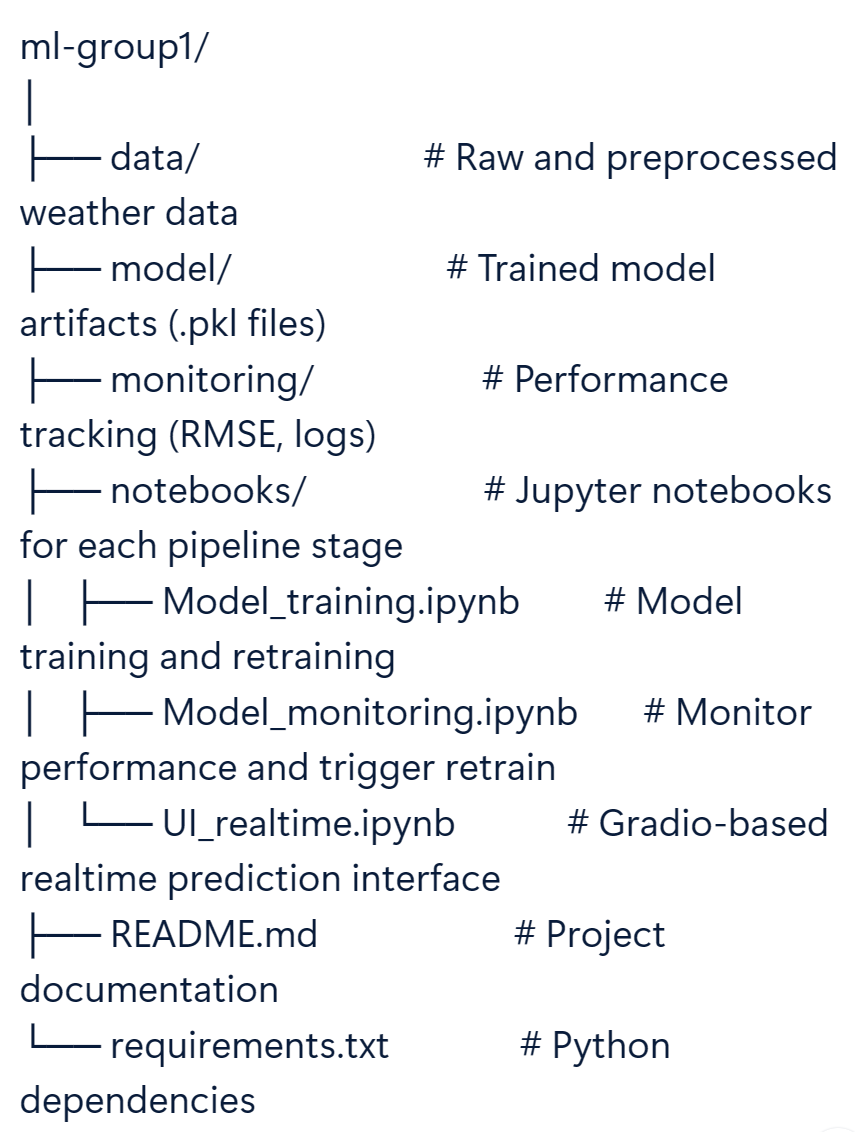

### 6. Preprocessing/ Feature Enginering/ Tuning/ Training / Đánh giá kết quả Hourly (dùng luôn lgb)
- Vẽ tổng quát Biểu đồ các step: input, output đầu ra mỗi step, thứ từ các step mũi tên như nào (Vẽ trên canva hay ppt r cop lại đây)
- Preprocessing:
   + Input: dữ liệu hourly bao nhiêu row, bao cột
   + Drop columns nào, làm gì, ... (Nói là LGB nên cũng không cần xử lí nhiều, chủ yếu bỏ mấy cột thừa)
   + Output: ...
- Feature Engineering:
   + Feature Engineering Hourly:
      - Input: từ Preprocessing (đang bao nhiêu row hourly, bao nhiêu column)
      - Giải thích qua làm gì:
      - Output: (Còn bao nhiêu cột Daily, Tạo bao nhiêu columns: ngắn gọn cho t với nhóm nhiệt độ thì lấy aggregate mean, max, min, với theo chu kì trong ngày, Nhóm mặt trời thì chỉ lấy mean, với cao nhất trong ngày, ... vv)
   + Feature Engineering Daily Adjusted to new feature in Hourly:
      - Input:
      - Giải thích qua làm gì, thêm cái gì đối với feature mới từ hourly
      - Output:

- Tuning/ Training:
   + Cho t cái bản tóm tắt metric so sánh (Before training chỉ số các fold, Sau training kết quả train/ test average, perday so sánh với Daily LGB luôn)
   + Trực quan hoá bằng biểu đồ đường, biểu đồ cột so sánh các metric RMSE, MAE, R2 nhìn cho dễ - đừng vẽ mỗi cái một dòng khó nhìn lắm, để hết vào 1 cái khung figure, rồi chia row, column trong đấy để biểu đồ vào


flowchart LR
    A["Data Preprocessing"] --> B["Feature Engineering"]
    B --> C["Temporal Features"]
    C --> D["Rolling Statistics"]
    D --> E["Target Generation"]
    E --> F["Final Dataset Preparation"]

    %% Data Preprocessing
    subgraph A1["Data Preprocessing"]
        A1i["Input: Raw weather CSV (VisualCrossing)"]
        A1p["Process: 
        - Load and sort by datetime
        - Drop redundant columns (icon, stations, etc.)
        - Handle missing & low-variance features
        - Convert dtype to category"]
        A1o["Output: Cleaned dataset (df_cleaned)"]
        A1i --> A1p --> A1o
    end

    %% Feature Engineering
    subgraph B1["Feature Engineering"]
        B1i["Input: df_cleaned"]
        B1p["Process: 
        - Date features: month, weekday, day_of_year, weekend, cyclical sin/cos encoding, sunrise/sunset, day_length
        - Specific features: temp_range, dew_spread, humidity_high, heavy_rain, thermal_index, heat_index, wind_chill, uv_cloud_index, solar_visibility_index, wind_category, season"]
        B1o["Output: Enriched dataset (df_feat_t)"]
        B1i --> B1p --> B1o
    end

    %% Temporal Features
    subgraph C1["Temporal Features"]
        C1i["Input: df_feat_t"]
        C1p["Process: 
        - Auto lag creation per config
        - Lags: 1h, 3h, 7d, 30d
        - Avoid data leakage with shift()"]
        C1o["Output: Lagged dataset (df_lagged)"]
        C1i --> C1p --> C1o
    end

    %% Rolling Statistics
    subgraph D1["Rolling Statistics"]
        D1i["Input: df_lagged"]
        D1p["Process:
        - Rolling mean, std, sum
        - Windows: 3, 5, 7, 14, 21 days
        - Shift 1 step before rolling"]
        D1o["Output: Smoothed temporal trends (df_rolled)"]
        D1i --> D1p --> D1o
    end

    %% Target Generation
    subgraph E1["Target Generation"]
        E1i["Input: df_rolled"]
        E1p["Process:
        - Create multi-horizon labels
        - temp_next_1 to temp_next_5
        - Drop NaNs at tail"]
        E1o["Output: Supervised dataset (X, y1–5)"]
        E1i --> E1p --> E1o
    end

    %% Final Dataset Preparation
    subgraph F1["Final Dataset Preparation"]
        F1i["Input: df_supervised"]
        F1p["Process:
        - Drop base features (optional)
        - Encode: Conditions, Wind, Season
        - Convert to categorical for LightGBM"]
        F1o["Output: Model-ready dataset (X_final, y_final)"]
        F1i --> F1p --> F1o
    end

    %% Main flow connections
    A1o --> B1i
    B1o --> C1i
    C1o --> D1i
    D1o --> E1i
    E1o --> F1i
  

  PASTE LEN MERMAID HO TAO, TAO LAM CANVA SAU: https://www.mermaidflow.app/editor

### 7. ONNX

In [ ]:
def lưu_nháp_kệ_đi():
   pass
   # hàm encoding conditions
   # condition = dp.ConditionsEncoder(is_category = False, encoding_method='target') # False tốt hơn
   # X_train = condition.fit_transform(X_train, X_train['temp'])
   # X_test = condition.transform(X_test)

   # # hàm encoding season
   # season = dp.SeasonClassifier(n_seasons=5, is_category = False) # False tốt hơn
   # X_train = season.fit_transform(X_train, X_train['temp'])
   # X_test = season.transform(X_test)

   # # hàm encoding wind
   # wind = dp.WindCategoryEncoder(is_category= False, n_quantiles= 4) # nếu không dùng kết hợp với condtions thì False tốt hơn
   # X_train = wind.fit_transform(X_train, X_train['temp'])
   # X_test = wind.transform(X_test)

   # # Nháp của t kệ đi
   # # Chạy code so sánh Numeric season vs Category season
   # # hàm encoding conditions
   # condition = dp.ConditionsEncoder(is_category = True, encoding_method='target') # False tốt hơn
   # train_feat = condition.fit_transform(train_feat, train_feat['temp'])
   # test_feat = condition.transform(test_feat)

   # # hàm encoding season
   # season = dp.SeasonClassifier(n_seasons=5, is_category = True) # False tốt hơn
   # train_feat = season.fit_transform(train_feat, train_feat['temp'])
   # test_feat = season.transform(test_feat)

   # # hàm encoding wind
   # wind = dp.WindCategoryEncoder(is_category= True) # nếu không dùng kết hợp với condtions thì False tốt hơn
   # train_feat = wind.fit_transform(train_feat, train_feat['temp'])
   # test_feat = wind.transform(test_feat)

   # # Chia X, y riêng biệt
   # X_train = train_feat.drop(columns= target_col)
   # y_train = train_feat[target_col]

   # X_test = test_feat.drop(columns= target_col)
   # y_test = test_feat[target_col]

   # print(f"Train: {X_train.shape, y_train.shape}, Test: {X_test.shape, y_test.shape}")

   # # Chạy code so sánh Numeric wind_cateogry vs Category wind_category


   # # Chạy code so sánh Numeric conditions vs Category conditions




   # from optuna.pruners import MedianPruner
   # from lightgbm import early_stopping

   # # ===  Tạo hàm objective ===
   # def objective(trial):
   #     boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])

   #     params = {
   #         'boosting_type': boosting_type,
   #         'max_depth': trial.suggest_int('max_depth', 3, 12),
   #         'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
   #         'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.3),
   #         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
   #         'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
   #         'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True),
   #         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
   #         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
   #         'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
   #         'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
   #         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
   #         'max_bin': trial.suggest_int('max_bin', 64, 512),
   #         'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),

   #         'objective': 'regression',
   #         'metric': 'rmse',
   #         'random_state': 42,
   #         'n_jobs': -1,
   #         'verbosity': -1  #
   #     }

   #     if boosting_type == 'dart':
   #         params['drop_rate'] = trial.suggest_float('drop_rate', 0.05, 0.5)
   #         params['skip_drop'] = trial.suggest_float('skip_drop', 0.3, 0.7)

   #     # === TimeSeriesSplit CV ===
   #     cv = TimeSeriesSplit(n_splits=5)
   #     rmse_scores = []

   #     for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_sel)):
   #         X_tr, X_val = X_train_sel.iloc[train_idx], X_train_sel.iloc[val_idx]
   #         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

   #         # Fit riêng cho từng cột output
   #         models_fold = {}
   #         y_pred_val = pd.DataFrame(index=y_val.index, columns=y_val.columns)

   #         for col in y_train.columns:
   #             model = LGBMRegressor(**params)
   #             model.fit(
   #                 X_tr, y_tr[col],
   #                 eval_set=[(X_val, y_val[col])],
   #                 eval_metric='rmse',
   #                 callbacks=[early_stopping(stopping_rounds=50, verbose=False)]

   #             )
   #             models_fold[col] = model
   #             y_pred_val[col] = model.predict(X_val)

   #         metrics = evaluate_multi_output(y_val, y_pred_val)
   #         rmse_fold = metrics["average"]["RMSE"]
   #         rmse_scores.append(rmse_fold)

   #         # Báo cho Optuna biết tiến độ trial
   #         trial.report(rmse_fold, step=fold_idx)
   #         if trial.should_prune():
   #             raise optuna.TrialPruned()

   #     mean_rmse = np.mean(rmse_scores)
   #     return mean_rmse

   # # === 3️ Cấu hình Pruner ===
   # pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=2, interval_steps=1)

   # # === 4 Chạy Optuna Study ===
   # sampler = optuna.samplers.TPESampler(seed=42)
   # study_grad = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)
   # study_grad.optimize(objective, n_trials=500, show_progress_bar=True)

   # # === 5️ In kết quả ===
   # print(" Best parameters:", study_grad.best_trial.params)
   # print(" Best RMSE (Optuna CV):", study_grad.best_value)

   # # === 6️ Fit lại với best params cho từng output ===
   # best_params = study_grad.best_trial.params
   # final_models = {}
   # y_pred_train = pd.DataFrame(index=y_train.index, columns=y_train.columns)
   # y_pred_test = pd.DataFrame(index=y_test.index, columns=y_test.columns)

   # for col in y_train.columns:
   #     model = LGBMRegressor(**best_params)
   #     model.fit(
   #         X_train_sel, y_train[col],
   #         eval_set=[(X_test_sel, y_test[col])],
   #         eval_metric='rmse',
   #         callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
   #     )

   #     final_models[col] = model
   #     y_pred_train[col] = model.predict(X_train_sel)
   #     y_pred_test[col] = model.predict(X_test_sel)

   # # Evaluate
   # bestGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)
   # bestGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

   # print("Best Model - Train metrics (average):", bestGrad_train_metrics["average"])
   # print("Best Model - Test metrics (average):", bestGrad_test_metrics["average"])
